In [1]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.integrate import odeint

In [2]:
common_settings = {
'omega_b':0.022,
'h':0.67,
'z_reio':7.6711,
'YHe':0.25,
'perturbations_verbose':1,
'background_verbose':3,
'output':'mTk, vTk, mPk',
'gauge':'newtonian',
'P_k_max_1/Mpc':10,
'z_max_pk':1000,
'format':'class',
'k_step_super_reduction':0.01
}

In [32]:
pureCDM = Class()
pureCDM.set(common_settings)

chiCDM = Class()
chiCDM.set(common_settings)

kval = 0.09

aNR=1.e-3
f_chi=0.1
print(f'aNR={aNR},zNR={1/aNR -1}')

chiCDM.set({
# 'f_chi':f_chi,
'acs_chi':aNR,
'cs2_peak_chi':1./3.,

'omega_cdm':0.12,
# 'omega_chi':0.02,
'f_chi':f_chi,
'k_output_values' : kval*0.67, #my kval is in h/Mpc units
# 'N_ur':0,
# 'T_cmb':1.9
})
chiCDM.compute()

pureCDM.set({
'omega_cdm':0.12+0.0157613,
'k_output_values' : kval*0.67, #my kval is in h/Mpc units
})
pureCDM.compute()


aNR=0.001,zNR=999.0
Running CLASS version v3.2.0
Computing background
Chose ndf15 as generic_evolver
 -> age = 13.448236 Gyr
 -> conformal age = 13621.513911 Mpc
 -> N_eff = 3.044 (summed over all species that are non-relativistic at early times) 
 -> radiation/matter equality at z = 3771.254146
    corresponding to conformal time = 101.800901 Mpc
 ---------------------------- Budget equation ----------------------- 
 ---> Nonrelativistic Species 
-> Bayrons                        Omega = 0.0490087       , omega = 0.022          
-> Cold Dark Matter               Omega = 0.26732         , omega = 0.12           
-> Dark Matter with sound speed:  Omega = 0.0351476       , omega = 0.0157778      
 ---> Relativistic Species 
-> Photons                        Omega = 5.50898e-05     , omega = 2.47298e-05    
-> Ultra-relativistic relics      Omega = 3.80844e-05     , omega = 1.70961e-05    
 ---> Other Content 
-> Cosmological Constant          Omega = 0.64843         , omega = 0.29108    

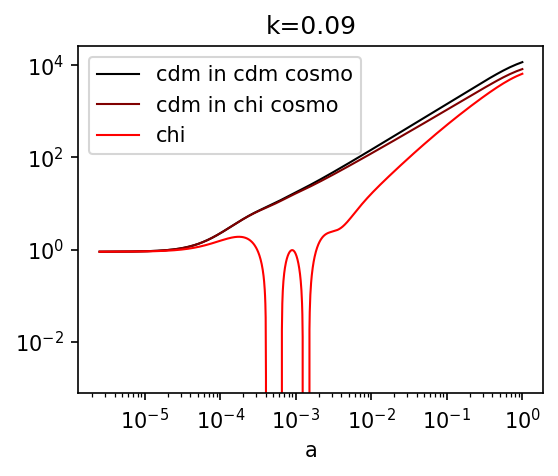

In [37]:
perts_chi = chiCDM.get_perturbations()['scalar']
perts_c = pureCDM.get_perturbations()['scalar']
a = perts_chi[0]['a']

f_b_overcb = 0.022/(0.12+0.022)
cb_chi = -(1-f_b_overcb)*perts_chi[0]['delta_cdm']-f_b_overcb*perts_chi[0]['delta_b']
f_b_overcb = 0.022/(0.12+0.0157+0.022)
cb_chi_int =interp1d(a, cb_chi)
cb_c =interp1d(perts_c[0]['a'], -(1-f_b_overcb)*perts_c[0]['delta_cdm']
-f_b_overcb*perts_c[0]['delta_b'], fill_value=0.5, bounds_error=False)


# error_pure_cdm=np.abs(P_end_D_EdS/Pk_end-1)

plt.figure(figsize=(4,3), dpi=150)

plt.plot(a, cb_c(a),'k',label=r'cdm in cdm cosmo', linewidth=1)
plt.plot(a, cb_chi,'maroon',label=r'cdm in chi cosmo', linewidth=1)

plt.plot(a, -perts_chi[0]['delta_chi'],'r',label=r'chi', linewidth=1)

plt.xscale('log')
plt.yscale('log')
# plt.ylim([3.e-3,1])
plt.xlabel('a')
plt.title(f'k={str(kval)}')
plt.legend(loc='upper left')

plt.show()

---
compute growth rate

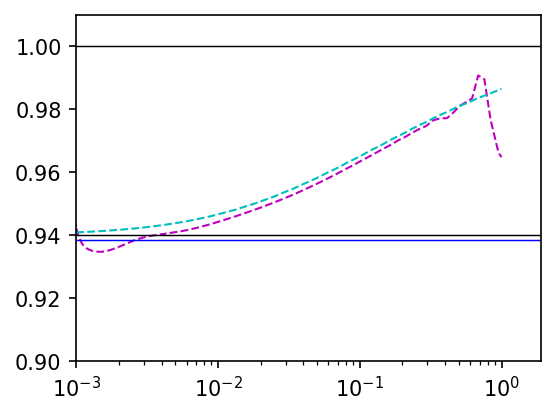

In [38]:
background = chiCDM.get_background() # load background table
kJ_int=interp1d(1/(background['z']+1),background['(.)kJ_chi'])
D_class_int = interp1d(1/(background['z']+1),background['gr.fac. D'])
f_lcdm = interp1d(1/(background['z']+1),background['gr.fac. f'])

def gh_system(w, t):
    g,h = w
    dgdt = h - g
    dhdt = 3/2 *(1-h)-3/2*np.exp(-t)*g
    return [dgdt, dhdt]
w0 = [0.,0.]
t = np.linspace(-10,30, 100)  #t is tilde eta
sol = odeint(gh_system, w0, t)
g_int = interp1d(t, sol[:, 0])
h_int = interp1d(t, sol[:, 1])

def s1_system(s1, t):
    ds1dt = -2.5*s1+1.5*(g_int(t)-1)
    return ds1dt
t = np.linspace(-10,25, 100)
sol = odeint(s1_system, -3/5, t)


s_int_te = interp1d(t, sol[:, 0], fill_value='extrapolate')

a_of_t = aNR* ((kval/kJ_int(aNR))**2 ) * np.exp(t) 
s_int_a = interp1d(a_of_t, sol[:, 0], fill_value='extrapolate')

f_ratiodev = np.gradient(np.log(cb_chi), np.log(cb_c(a)))
fg_cdm = np.gradient(np.log(cb_chi), np.log(a))
fg_cdm_c = np.gradient(np.log(cb_c(a)), np.log(a))

plt.figure(figsize=(4,3), dpi=150)

# plt.plot(a, f_lcdm(a)*(1+f_chi*s_int_te(te_of_a)),'green',label=r'cdm in cdm cosmo', linewidth=1)
# plt.plot(a, fg_cdm,'maroon',label=r'cdm in cdm cosmo', linewidth=1)
# plt.plot(1/(background['z']+1),background['gr.fac. f'],'b',label=r'cdm in cdm cosmo', linewidth=1)
plt.plot(a, f_ratiodev,'m--',label=r'cdm in cdm cosmo', linewidth=1)
# plt.plot(a, fg_cdm/f_lcdm(a),'g--',label=r'cdm in cdm cosmo', linewidth=1)

plt.plot(a, (1+f_chi*s_int_a(a)),'c--',label=r'cdm in cdm cosmo', linewidth=1)
plt.axhline(y=1-3/5*f_chi,linewidth=0.7, color='k')
plt.axhline(y=5/4*np.sqrt(1-24/25*f_chi)-1/4,linewidth=0.7, color='b')

# plt.plot(a, np.abs(f_lcdm(a)*(1+f_chi*s_int_te(a))/fg_cdm-1),'k--',label=r'cdm in cdm cosmo', linewidth=1)

plt.axhline(y=1,linewidth=0.7, color='k')
plt.xscale('log')
# plt.yscale('log')
plt.xlim([0.001,None])
plt.ylim([0.9,1.01])

plt.show()

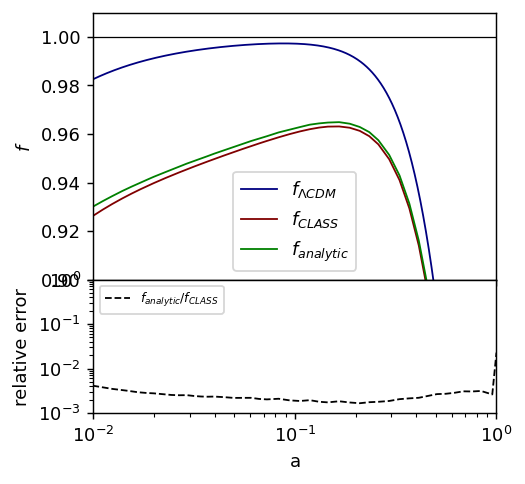

In [39]:
fig, axs = plt.subplots(2, 1, sharex=True,gridspec_kw={'height_ratios': [2,1]}, figsize=(4,4), dpi=130)
plt.subplots_adjust(hspace = 0)

axs[0].plot(1/(background['z']+1),background['gr.fac. f'],'navy',label=r'$f_{\Lambda CDM}$', linewidth=1)
axs[0].plot(a, fg_cdm,'maroon',label=r'$f_{CLASS}$', linewidth=1)
axs[0].plot(a, f_lcdm(a)*(1+f_chi*s_int_a(a)),'green',label=r'$f_{analytic}$', linewidth=1)

axs[0].axhline(y=1,linewidth=0.7, color='k')

axs[1].plot(a, np.abs(f_lcdm(a)*(1+f_chi*s_int_a(a))/fg_cdm-1),'k--',label=r'$f_{analytic}/f_{CLASS}$', linewidth=1)


# axs[0].text(0.06, 0.75, r'$f_\chi = '+str(int(f_chi*100))+'\%, \; k='+str(kval)+'$', fontsize=11)


axs[0].legend(loc='best')
axs[0].set_xlim([1.e-2,1])
axs[0].set_xscale('log')
axs[1].set_xlabel('a')
axs[1].legend(loc='upper left', fontsize=7, ncol=4)
axs[1].set_ylim([1.e-3,1])
axs[1].set_yscale('log')

axs[0].set_ylim([0.9,1.01])
axs[0].set_ylabel(r'$f$')
axs[1].set_ylabel('relative error')

# plt.savefig('/home/fverdian/class/soundspeed-scripts/figure/growthfact-error-fx01.pdf',bbox_inches='tight')

plt.show()

----
now its integral

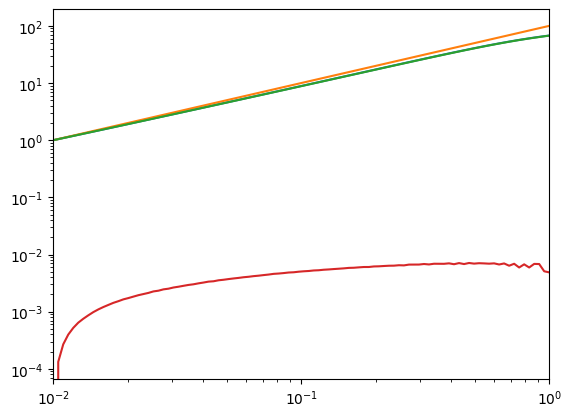

In [40]:
a_ini=0.01;a_end=0.5

s_int_te = interp1d(t, sol[:, 0], fill_value='extrapolate')
te_ini_of_ak=np.log(a_ini/aNR) - 2*np.log(kval/kJ_int(aNR))
te_end_of_ak=np.log(a_end/aNR) - 2*np.log(kval/kJ_int(aNR))

aeval=np.logspace(-2,0,100)
Delta_logD_k=[]
for ae in aeval:
    te_end_of_ak=np.log(ae/aNR) - 2*np.log(kval/kJ_int(aNR))
    D_integral, D_error = quad(s_int_te, te_ini_of_ak, te_end_of_ak,epsrel=1.e-4)
    Delta_logD_k.append(D_integral)

D_a = (D_class_int(aeval)/D_class_int(a_ini))*np.exp(f_chi*np.array(Delta_logD_k)) 

plt.loglog(aeval, D_a)
plt.loglog(aeval, aeval/a_ini)
plt.loglog(aeval, cb_chi_int(aeval)/cb_chi_int(a_ini))

plt.loglog(aeval, np.abs(cb_chi_int(aeval)/cb_chi_int(a_ini)/D_a-1))

plt.xlim([0.01,1])
plt.show()
